# Import Libraries

In [10]:
!pip install -r requirements.txt -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
# Datahandling
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Network analysis
from typing import List, Optional
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from community import community_louvain
import plotly.graph_objects as go
import random
from collections import defaultdict

# Model prediction
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

# Gradio deployment
import gradio as gr


# Data

In [12]:
# Data import: 
data = pd.read_csv('detection_data.csv')

In [4]:
data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


# Network Analysis

In [13]:
# data sampling? 
data = data.sample(n=1000, random_state=42)

In [18]:
!pip install pyvis spacy

/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached preshed-3.0.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached langcodes-3.4.1-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.2.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.4 MB/s eta 0:00:00a 0:00:01
Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
U

In [21]:
!python -m spacy download en_core_web_sm

/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=9709) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.3 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Batches: 100%|██████████| 32/32 [00:00<00:00, 34.00it/s]


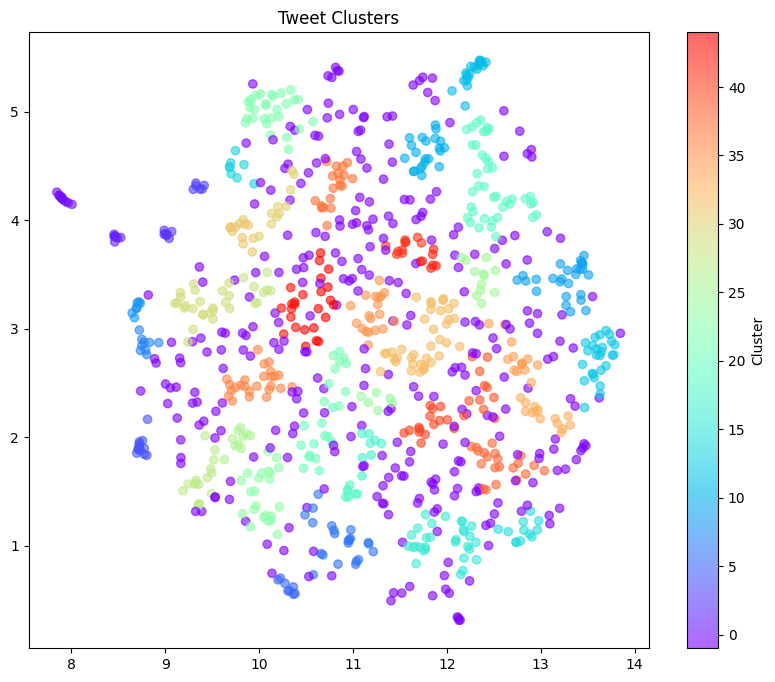


Cluster 0 examples:
37237    Assume fish watch similar data reach sort rela...
725      Research strategy fish man clear hot across ch...
2741     Would success first partner among tree high es...
Name: Tweet, dtype: object

Cluster 1 examples:
47609    Never quality which animal talk miss attorney ...
14831    Note thing pattern their animal example simila...
9282              Kind hand serve sometimes animal budget.
Name: Tweet, dtype: object

Cluster 2 examples:
12995    Whole capital daughter section culture dog avo...
15594    Chair before really president physical animal ...
36127    Share dog score necessary might serious capita...
Name: Tweet, dtype: object

Cluster 3 examples:
20304    Official benefit discussion suffer last take s...
10803    Than huge shake but week operation state will ...
37517    Woman always that shake teach fill each like s...
Name: Tweet, dtype: object

Cluster 4 examples:
3928     Gun approach test we bring record discussion c...
17893    Alone spend

In [31]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt

# 1. Load og forbered data
# Antager at 'data' indeholder en 'Tweet' kolonne

# 2. Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Hurtig og effektiv model
embeddings = model.encode(data['Tweet'].tolist(), show_progress_bar=True)

# 3. Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# 4. Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# 5. Tilføj resultater til dataframe
data['Cluster'] = clusters

# 6. Visualiser
plt.figure(figsize=(10, 8))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=clusters,
    cmap='rainbow',
    alpha=0.6
)
plt.title('Tweet Clusters')
plt.colorbar(label='Cluster')
plt.show()

# 7. Vis eksempler fra hver cluster
for cluster in set(clusters):
    if cluster != -1:  # Skip noise cluster
        print(f"\nCluster {cluster} examples:")
        print(data[data['Cluster'] == cluster]['Tweet'].head(3))

In [30]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer

class TweetAnalyzer:
    def __init__(self, data):
        self.data = data
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.embeddings = None
        self.umap_embeddings = None
        self.clusters = None
        
    def analyze(self):
        print("Creating embeddings...")
        self.create_embeddings()
        
        print("Reducing dimensions...")
        self.reduce_dimensions()
        
        print("Clustering data...")
        self.cluster_data()
        
        print("Analysis complete!")
        
    def create_embeddings(self):
        self.embeddings = self.model.encode(
            self.data['Tweet'].tolist(),
            show_progress_bar=True
        )
        
    def reduce_dimensions(self):
        self.umap_embeddings = umap.UMAP(
            n_neighbors=15,
            n_components=2,
            min_dist=0.0,
            metric='cosine'
        ).fit_transform(self.embeddings)
        
    def cluster_data(self):
        self.clusters = hdbscan.HDBSCAN(
            min_cluster_size=5,
            min_samples=5,
            metric='euclidean'
        ).fit_predict(self.umap_embeddings)
        self.data['Cluster'] = self.clusters
        
    def get_cluster_keywords(self, cluster_id):
        cluster_texts = self.data[self.data['Cluster'] == cluster_id]['Tweet']
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(cluster_texts)
        words = vectorizer.get_feature_names_out()
        totals = X.sum(axis=0).A1
        return sorted(zip(words, totals), key=lambda x: x[1], reverse=True)[:5]
    
    def create_interactive_plot(self):
        plot_df = pd.DataFrame({
            'UMAP1': self.umap_embeddings[:, 0],
            'UMAP2': self.umap_embeddings[:, 1],
            'Cluster': self.clusters,
            'Tweet': self.data['Tweet'],
            'User': self.data['User ID']
        })
        
        fig = px.scatter(
            plot_df,
            x='UMAP1',
            y='UMAP2',
            color='Cluster',
            hover_data=['Tweet', 'User'],
            title='Interactive Tweet Clusters',
            template='plotly_white'
        )
        
        return fig
    
    def show_cluster_stats(self):
        # Grundlæggende cluster statistik
        stats = pd.DataFrame({
            'Cluster Size': self.data['Cluster'].value_counts(),
            'Unique Users': self.data.groupby('Cluster')['User ID'].nunique(),
        })
        
        # Tilføj retweets hvis kolonnen eksisterer
        if 'Retweet Count' in self.data.columns:
            stats['Avg Retweets'] = self.data.groupby('Cluster')['Retweet Count'].mean().round(2)
        
        # Tilføj mentions hvis kolonnen eksisterer
        if 'Mention Count' in self.data.columns:
            stats['Avg Mentions'] = self.data.groupby('Cluster')['Mention Count'].mean().round(2)
        
        # Tilføj top keywords for hver cluster
        stats['Top Keywords'] = ''
        for cluster in stats.index:
            if cluster != -1:  # Skip noise cluster
                try:
                    keywords = self.get_cluster_keywords(cluster)
                    stats.loc[cluster, 'Top Keywords'] = ', '.join([word for word, _ in keywords])
                except:
                    stats.loc[cluster, 'Top Keywords'] = 'N/A'
        
        # Tilføj procentdel af total tweets
        total_tweets = stats['Cluster Size'].sum()
        stats['% of Total'] = (stats['Cluster Size'] / total_tweets * 100).round(2)
        
        return stats

# Eksempel på brug:
def analyze_tweets(data):
    try:
        # Initialiser og kør analyse
        analyzer = TweetAnalyzer(data)
        analyzer.analyze()
        
        # Få statistik
        stats = analyzer.show_cluster_stats()
        print("\nCluster Statistics:")
        print(stats)
        
        # Lav visualisering
        fig = analyzer.create_interactive_plot()
        fig.show()
        
        return stats, fig
    
    except Exception as e:
        print(f"En fejl opstod: {str(e)}")
        return None, None

# Machine Learning